In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import spacy

from scipy import sparse

In [5]:
train=pd.read_csv('train_data.txt',sep=':::',header=None,names=['id','title','genre','description'])
test=pd.read_csv('test_data_solution.txt',sep=':::',header=None,names=['id','title','genre','description'])

In [6]:
train

,id,title,genre,description
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...
...,...,...,...,...
4757,4758,Angshumaner Chhobi (2009),drama,"Angshuman, a young film director, comes back ..."
4758,4759,Kamerayla Izdivac (2010),documentary,The film shows us the unknown face of TV worl...
4759,4760,Lost: 2010 PaleyFest (2010),talk-show,The exclusive release of the PaleyFest2010 li...
4760,4761,Oy Vey! My Son Is Gay!! (2009),comedy,A romantic comedy featuring a Jewish family w...


In [7]:
test

,id,title,genre,description
0,1,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),drama,Before he was known internationally as a mart...
...,...,...,...,...
9618,9619,Wan Mei You Duo Mei (2017),family,"In the film, the protagonist finds a door con..."
9619,9620,Let's Tie Up Aunt Holly (2016),adult,Resentful that her Aunt Holly won't let her g...
9620,9621,The Joe Moses One-Man Showses (2012),comedy,"Featuring original sketch comedy, improvisati..."
9621,9622,The Truth About Julie Goodyear (2002),documentary,Channel 5's intimate documentary about ex-'Co...


In [8]:
train=train.drop(['id'],axis=1)
test=test.drop(['id'],axis=1)

In [9]:
train['title'][0].split('(')[-1][:4]

'2009'

In [10]:
train['title'][0].split('(')[:-1][0]

' Oscar et la dame rose '

In [11]:
def extract_year(data):
    if data.split('(')[-1][:4].isdigit():
        return int(data.split('(')[-1][:4])
    return None

train['year']=train['title'].apply(extract_year)
test['year']=test['title'].apply(extract_year)

In [12]:
def transform_title(data):
    if data.split('(')[-1][:4].isdigit():
        return data.split('(')[:-1][0]
    return None

train['title']=train['title'].apply(transform_title)
test['title']=test['title'].apply(transform_title)

In [13]:
train

,title,genre,description,year
0,Oscar et la dame rose,drama,Listening in to a conversation between his do...,2009.0
1,Cupid,thriller,A brother and sister with a past incestuous r...,1997.0
2,"Young, Wild and Wonderful",adult,As the bus empties the students for their fie...,1980.0
3,The Secret Sin,drama,To help their unemployed father make ends mee...,1915.0
4,The Unrecovered,drama,The film's title refers not only to the un-re...,2007.0
...,...,...,...,...
4757,Angshumaner Chhobi,drama,"Angshuman, a young film director, comes back ...",2009.0
4758,Kamerayla Izdivac,documentary,The film shows us the unknown face of TV worl...,2010.0
4759,Lost: 2010 PaleyFest,talk-show,The exclusive release of the PaleyFest2010 li...,2010.0
4760,Oy Vey! My Son Is Gay!!,comedy,A romantic comedy featuring a Jewish family w...,2009.0


In [14]:
missing_val=train.isna().sum()['year']
total_val=train.shape[0]
print(f'"Year" Column on train dataset got {(missing_val/total_val)*100} percent missing values.')

"Year" Column on train dataset got 4.871902561948762 percent missing values.


In [15]:
missing_val=test.isna().sum()['year']
total_val=test.shape[0]
print(f'"Year" Column on test dataset got {(missing_val/total_val)*100} percent missing values.')

"Year" Column on test dataset got 5.1127507014444555 percent missing values.


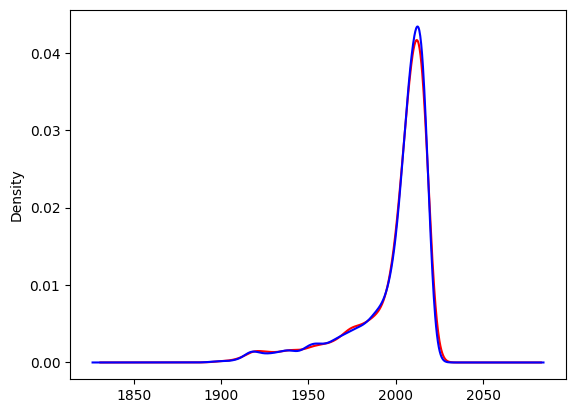

In [16]:
train['year'].plot(kind='kde',color='red')
test['year'].plot(kind='kde',color='blue')
plt.show()

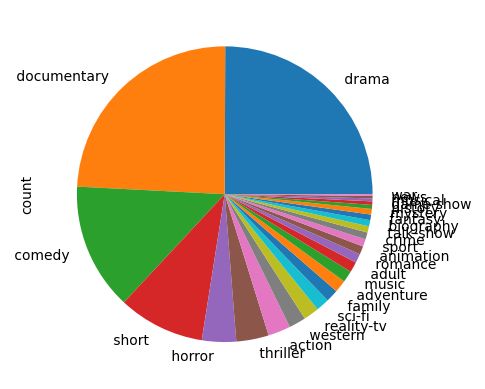

In [17]:
train['genre'].value_counts().plot(kind='pie')
plt.show()

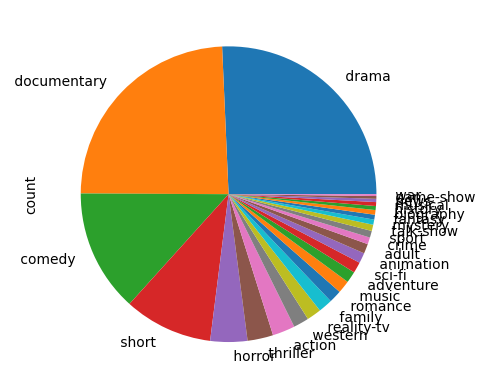

In [18]:
test['genre'].value_counts().plot(kind='pie')
plt.show()

In [19]:
# making x_train & y_train and x_test & y_test

x_train=train.drop('genre',axis=1)
y_train=train['genre']

x_test=test.drop('genre',axis=1)
y_test=test['genre']

In [20]:
tran_imputing_na_101 = ColumnTransformer(
    [("fill_na", SimpleImputer(missing_values=np.nan, strategy='mean'), [-1])],remainder='passthrough')

# put bins on year column
tran_binning_102 = ColumnTransformer(
    [("binning_year", KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile'), [0])],remainder='passthrough')

pipeline_101 = Pipeline([('Imputing_values',tran_imputing_na_101),('Binning',tran_binning_102)])

In [21]:
x_train=pipeline_101.fit_transform(x_train)
x_test=pipeline_101.fit_transform(x_test)

In [22]:
class merge(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self,data,y=None):
        return self
    def transform(self,data,y=None):
        #data=np.array(data)
        for i in range(data.shape[0]):
            one_cell=''
            for individual in data[i]:
                one_cell += str(individual)
            data[i]=one_cell
        return data[:,:1].flatten()


# merging all the individual columns and making them one
pipeline_201 = Pipeline([('merging_columns_into_single',merge())])

In [23]:
x_train=pipeline_201.fit_transform(x_train)
x_test=pipeline_201.fit_transform(x_test)

In [24]:
class text_processing(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self,data,y=None):
        return self
    def transform(self,data,y=None):
        for i in range(data.shape[0]):
            filter_token=''
            for token in nlp(data[i]):
                if not token.is_punct and not token.is_stop:
                    filter_token+=(token.lower_+' ')
            data[i]=filter_token
        return data


nlp=spacy.load('en_core_web_sm') # making a spacy object
# implementing text processing
pipeline_301 = Pipeline([('merging_columns_into_single',text_processing())])

In [25]:
x_train=pipeline_301.fit_transform(x_train)
x_test=pipeline_301.transform(x_test)

In [26]:
pipeline_401 = Pipeline([('tf_idf_vector',TfidfVectorizer())])

In [27]:
x_train=pipeline_401.fit_transform(x_train)
x_test=pipeline_401.transform(x_test)

In [28]:
x_train=sparse.csr_matrix(x_train)
x_test=sparse.csr_matrix(x_test)

In [29]:
label_encoder=LabelEncoder()

y_train=label_encoder.fit_transform(y_train)
y_test=label_encoder.fit_transform(y_test)

In [30]:
clf = BernoulliNB(alpha=2,fit_prior=False,binarize=0.019).fit(x_train,y_train)
y_pred=clf.predict(x_test)
accuracy_score(y_test, y_pred)

0.43697391665800683

In [31]:
neigh = KNeighborsClassifier(n_neighbors=230,weights='distance').fit(x_train,y_train)
y_pred=neigh.predict(x_test)
accuracy_score(y_test, y_pred)

0.4351033981086979

In [32]:
rfc = RandomForestClassifier(n_estimators=195, random_state=42).fit(x_train,y_train)
y_pred=rfc.predict(x_test)
accuracy_score(y_test, y_pred)

0.45993972773563335

In [33]:
clf = LogisticRegression(multi_class='multinomial',solver='saga').fit(x_train,y_train)
y_pred=clf.predict(x_test)
accuracy_score(y_test, y_pred)

0.47656655928504627